In [1]:
# !pip install stable_baselines3

In [2]:
from gym import Env
from gym.spaces import Box
import numpy as np

class TrafficLightEnv(Env):
  def __init__(self, roads_count, change_size, max_value):

    self.roads_count = roads_count
    self.max_value = max_value
    self.change_size = change_size
    self.iterations = 100

    # For each road: 0:-change_size 1:0 2:+change_size and also change all
    # self.action_space = MultiDiscrete([3 for _ in range(self.roads_count)], dtype=np.int8)
    self.action_space = Box(low=0, high=1, shape=(roads_count*3 + 3,)) # Optimized for deep learning

    # Observations
    # self.observation_space= Dict({
    #   'green light timer': Box(low=0, high=100, dtype=np.int16, shape=(self.roads_count,)),
    #   'avg waiting times' : Box(low=0, high=100, dtype=np.float16, shape=(self.roads_count,)),
    #   'vehicles counts' : Box(low=0, high=100, dtype=np.int16, shape=(self.roads_count,)),
    #   'in counts' : Box(low=0, high=100, dtype=np.int16, shape=(self.roads_count,)),
    #   'out counts' : Box(low=0, high=100, dtype=np.int16, shape=(self.roads_count,)),
    #   'avg speeds' : Box(low=0, high=100, dtype=np.float16, shape=(self.roads_count,)),
    # })
    self.observation_space = Box(low=0,high=max_value,shape=(24,)) # Optimized for deep learning

    # Each road timer (main state)
    self.green_light_timer = np.round(self.observation_space.sample()[0 : self.roads_count])
    # average waiting time of each road
    self.avg_waiting_times = np.array([np.sum([rt if i!=r else 0 for i,rt in enumerate(self.green_light_timer)]) for r in range(self.roads_count)])
    # vehicles average speed
    self.avg_speeds = np.round(self.observation_space.sample()[self.roads_count*2 : self.roads_count*3])
    # vehicles stopped in each road
    self.vehicles_counts = np.round(self.observation_space.sample()[self.roads_count*3 : self.roads_count*4])
    # vehicles passed in green light of each road
    self.in_counts = np.round(self.observation_space.sample()[self.roads_count*4 : self.roads_count*5])
    # vehicles passed out of each road
    self.out_counts = np.round(self.observation_space.sample()[self.roads_count*5 : self.roads_count*6])

    # other var if needed = self.observation_space.sample()[self.roads_count*6 : self.roads_count*7] ...


  def reset(self):

    # Reset environment variables to initial state for a new episode
    super().reset()
    self.green_light_timer = np.round(self.observation_space.sample()[0 : self.roads_count])
    self.avg_waiting_times = np.array([np.sum([rt if i!=r else 0 for i,rt in enumerate(self.green_light_timer)]) for r in range(self.roads_count)])
    self.avg_speeds = np.round(self.observation_space.sample()[self.roads_count*2 : self.roads_count*3])
    self.vehicles_counts = np.round(self.observation_space.sample()[self.roads_count*3 : self.roads_count*4])
    self.in_counts = np.round(self.observation_space.sample()[self.roads_count*4 : self.roads_count*5])
    self.out_counts = np.round(self.observation_space.sample()[self.roads_count*5 : self.roads_count*6])
    self.iterations = 100
    
    state = np.reshape([self.green_light_timer,self.avg_waiting_times,self.vehicles_counts,self.in_counts,self.out_counts,self.avg_speeds],-1)

    return state
  
  def cast_action(self, action):
    action = np.reshape(action, newshape=(self.roads_count+1,3)) # convert to road*action shape
    return np.argmax(action, axis=1) # convert from one_hot

  def render(self):
        print('green light timer', self.green_light_timer)
        print('avg waiting times (-)', self.avg_waiting_times)
        print('vehicles counts (-)', self.vehicles_counts)
        print('in counts (+)', self.in_counts)
        print('out counts (+)', self.out_counts)
        print('avg speeds (+)', self.avg_speeds)


  # action is a list of one-hot encoded action for each road (road_count*3)
  def step(self, action):

    action = self.cast_action(action)

    # apply action on each raod green light timer: 0:-10 1:0 2:+10
    for r in range(self.roads_count):
        # decrease
        if(action[r]==0):
            if(self.green_light_timer[r]>10):
                self.green_light_timer[r] -= self.change_size
        # increase
        elif(action[r]==2):
            self.green_light_timer[r] += self.change_size
        else:
            pass

    # change all green timers (increase or decrease if not causes negative)
    # decrease
    if(action[-1]==0):
        # if all timer are bigger that dec value
        if(all(i > self.change_size*2 for i in self.green_light_timer)):
            self.green_light_timer = np.subtract(self.green_light_timer, self.change_size*2)
    # increase
    elif(action[-1]==2):
        self.green_light_timer = np.add(self.green_light_timer, self.change_size*2)
    else:
        pass

    # ---------------------------- #
    #  Simulating input variables  #
    # ---------------------------- #

    # calcualte red ligh time based on other roads green light timer
    for r in range(self.roads_count):
      self.avg_waiting_times[r] = np.sum([rt if i!=r else 0 for i,rt in enumerate(self.green_light_timer)])

    # calcualte vehicles passed in the green light
    for r in range(self.roads_count):
      if self.vehicles_counts[r] > 0:
          self.in_counts[r] = min(self.vehicles_counts[r], self.green_light_timer[r])
      else:
         self.in_counts[r] = 0

    # calcualte vehicles passed out
    rands = np.random.randint(0,self.in_counts.sum(),self.roads_count)
    rands = np.round((rands/np.sum(rands))*self.in_counts.sum()) # make sure sum of the is sum of inputs
    self.out_counts = rands
    
    # calculate vehicles count 
    for r in range(self.roads_count):
      self.vehicles_counts[r] -= self.in_counts[r]
      if self.max_value - self.vehicles_counts[r] > 0:
          self.vehicles_counts[r] += np.random.randint(0, self.max_value - self.vehicles_counts[r])

      self.iterations -= 1
      done = True if self.iterations<0 else False


    # ------------------------ #
    #          Reward          #
    # ------------------------ #

    reward = 0
    # Penalties (weighted)
    reward -= self.avg_waiting_times.sum()
    reward -=  self.vehicles_counts.sum()
    # Fairness (wighted)
    reward -= (np.max(self.avg_waiting_times) - np.min(self.avg_waiting_times))*2
    # Reward
    reward += self.in_counts.sum()
    # reward += self.out_counts.sum()
    # reward += self.avg_speeds.sum()

    state = np.reshape([self.green_light_timer,self.avg_waiting_times,self.vehicles_counts,self.in_counts,self.out_counts,self.avg_speeds],-1)

    info = {}

    # Return new state, reward and info dictionary
    return state, reward, done, info


In [3]:
ROAD_COUNTS = 4
CHANGE_SIZE = 10
MAX_STATE_VALUE = 500

In [4]:
env = TrafficLightEnv(roads_count=ROAD_COUNTS,change_size=CHANGE_SIZE,max_value=MAX_STATE_VALUE)

In [5]:
env.render()

green light timer [283. 316. 339.  42.]
avg waiting times (-) [697. 664. 641. 938.]
vehicles counts (-) [161. 358. 488. 400.]
in counts (+) [253. 216.  65. 427.]
out counts (+) [102. 415. 249. 203.]
avg speeds (+) [384. 236. 462. 459.]


In [6]:
action = env.action_space.sample()
print('raw action:', action)
action = env.cast_action(action)
print('\ncasted action:', action)

raw action: [0.36591318 0.89527744 0.35251284 0.7333681  0.7866822  0.7208899
 0.6153368  0.84349716 0.37469026 0.1851228  0.1003002  0.7571888
 0.7596826  0.46809515 0.5331479 ]

casted action: [1 1 1 2 0]


In [7]:
episodes = 1
state = env.reset()
score = 0 
for episode in range(episodes):
    done = False
    while not done:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        print('action:', env.cast_action(action))
        print('')
        score+=reward
    print('Episode:{} Score:{}'.format(episode+1, score))

green light timer [142. 320.  34. 482.]
avg waiting times (-) [836. 658. 944. 496.]
vehicles counts (-) [ 51. 397. 108. 464.]
in counts (+) [161. 147. 297. 395.]
out counts (+) [181. 225. 228. 363.]
avg speeds (+) [267. 373.  72. 328.]
action: [1 1 1 0 0]

green light timer [122. 300.  14. 452.]
avg waiting times (-) [766. 588. 874. 436.]
vehicles counts (-) [207. 187. 321. 153.]
in counts (+) [ 51. 300.  14. 452.]
out counts (+) [ 19.  86. 392. 321.]
avg speeds (+) [267. 373.  72. 328.]
action: [0 2 1 2 0]

green light timer [112. 310.  14. 462.]
avg waiting times (-) [786. 588. 884. 436.]
vehicles counts (-) [421. 462. 356. 105.]
in counts (+) [112. 187.  14. 153.]
out counts (+) [100. 131. 112. 123.]
avg speeds (+) [267. 373.  72. 328.]
action: [2 2 1 1 0]

green light timer [122. 320.  14. 462.]
avg waiting times (-) [796. 598. 904. 456.]
vehicles counts (-) [478. 263. 457. 105.]
in counts (+) [122. 320.  14. 105.]
out counts (+) [ 57. 144. 216. 144.]
avg speeds (+) [267. 373.  72.

In [8]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print('states:',state_size)
print('actions:',action_size)

states: 24
actions: 15


# Deep Q Learning

In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
# Define the Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 64)
        self.fc6 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [11]:
# Define Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.001):
        # Initialize agent parameters
        self.state_size = state_size  # Dimensionality of the state space
        self.action_size = action_size  # Number of possible actions
        self.memory = []  # Replay memory to store experiences
        self.batch_size = 64  # Batch size for training
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.lr = lr  # Learning rate for the optimizer
        
        # Define the main model and target model
        self.model = DQN(state_size, action_size)  # Main Q-network
        self.target_model = DQN(state_size, action_size)  # Target Q-network
        self.target_model.load_state_dict(self.model.state_dict())  # Initialize target model with the same weights
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)  # Optimizer for training the main model

    def remember(self, state, action, reward, next_state, done):
        # Store experience tuple (state, action, reward, next_state, done) in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Choose an action based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return env.action_space.sample()
        else:
            # Exploitation: Choose the action with the highest Q-value
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            q_values = self.model(state)
            return q_values.squeeze(0).detach().numpy()

    def replay(self):
        # Experience replay: Train the model using experiences stored in memory
        if len(self.memory) < self.batch_size:
            return
        # Sample a mini-batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                # Compute the target Q-value using the target model
                next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
                target = reward + self.gamma * torch.max(self.target_model(next_state)).item()
            # Update the Q-value of the chosen action
            target_f = self.model(torch.tensor(state, dtype=torch.float).unsqueeze(0)).squeeze(0).tolist()
            action_index = np.argmax(action)
            target_f[action_index] = target
            states.append(state)
            targets.append(target_f)
        # Compute and minimize the Mean Squared Error loss
        self.optimizer.zero_grad()
        states = torch.tensor(np.array(states), dtype=torch.float)
        targets = torch.tensor(np.array(targets), dtype=torch.float)
        loss = F.mse_loss(self.model(states), targets)
        loss.backward()
        self.optimizer.step()
        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network weights every few steps (e.g., every 50 steps)
        if len(self.memory) % 50 == 0:
            self.update_target_model()

    def update_target_model(self):
        # Update the weights of the target network with the weights of the main network
        self.target_model.load_state_dict(self.model.state_dict())


In [12]:
# Initialize the DQN agent
agent = DQNAgent(state_size, action_size,epsilon_decay=0.995,epsilon_min=0.01)

# Train the agent
EPISODES = 1000
episode_rewards = []
for episode in range(1, EPISODES + 1):
    state = env.reset()
    done = False
    reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
    env.render()
    agent.replay()
    episode_rewards.append(reward)
    print(f"Episode: {episode}/{EPISODES}, Reward: {reward}\n")

# Close the environment
# env.close()

green light timer [197. 184.  28.  54.]
avg waiting times (-) [266. 279. 435. 409.]
vehicles counts (-) [320. 279. 485. 356.]
in counts (+) [197. 184.  28.  54.]
out counts (+) [ 86. 120. 130. 126.]
avg speeds (+) [355. 331.  91. 187.]
Episode: 1/1000, Reward: -2704.0

green light timer [410. 136. 371. 422.]
avg waiting times (-) [ 929. 1203.  968.  917.]
vehicles counts (-) [191. 470. 189. 457.]
in counts (+) [275. 136. 241. 422.]
out counts (+) [134. 308. 374. 258.]
avg speeds (+) [237. 494. 453. 450.]
Episode: 2/1000, Reward: -4822.0

green light timer [ 93. 138. 285. 219.]
avg waiting times (-) [642. 597. 450. 516.]
vehicles counts (-) [453. 389. 356.  77.]
in counts (+) [ 93. 138.  26. 132.]
out counts (+) [ 27. 125. 149.  88.]
avg speeds (+) [353. 440. 384.   8.]
Episode: 3/1000, Reward: -3475.0

green light timer [200.  82. 102. 175.]
avg waiting times (-) [359. 477. 457. 384.]
vehicles counts (-) [ 53. 307. 327. 246.]
in counts (+) [200.  82. 102.  19.]
out counts (+) [130.  24

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

In [14]:
def plot_history(point_history, **kwargs):

    lower_limit = 0
    upper_limit = len(point_history)

    window_size = (upper_limit * 10) // 100

    plot_rolling_mean_only = False
    plot_data_only = False

    if kwargs:
        if "window_size" in kwargs:
            window_size = kwargs["window_size"]

        if "lower_limit" in kwargs:
            lower_limit = kwargs["lower_limit"]

        if "upper_limit" in kwargs:
            upper_limit = kwargs["upper_limit"]

        if "plot_rolling_mean_only" in kwargs:
            plot_rolling_mean_only = kwargs["plot_rolling_mean_only"]

        if "plot_data_only" in kwargs:
            plot_data_only = kwargs["plot_data_only"]

    points = point_history[lower_limit:upper_limit]

    # Generate x-axis for plotting.
    episode_num = [x for x in range(lower_limit, upper_limit)]

    # Use Pandas to calculate the rolling mean (moving average).
    rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

    plt.figure(figsize=(10, 7), facecolor="white")

    if plot_data_only:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
    elif plot_rolling_mean_only:
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")
    else:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

    text_color = "black"

    ax = plt.gca()
    ax.set_facecolor("black")
    plt.grid()
    plt.xlabel("Episode", color=text_color, fontsize=30)
    plt.ylabel("Total Points", color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter("{x:,}")
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis="x", colors=text_color)
    ax.tick_params(axis="y", colors=text_color)
    plt.show()

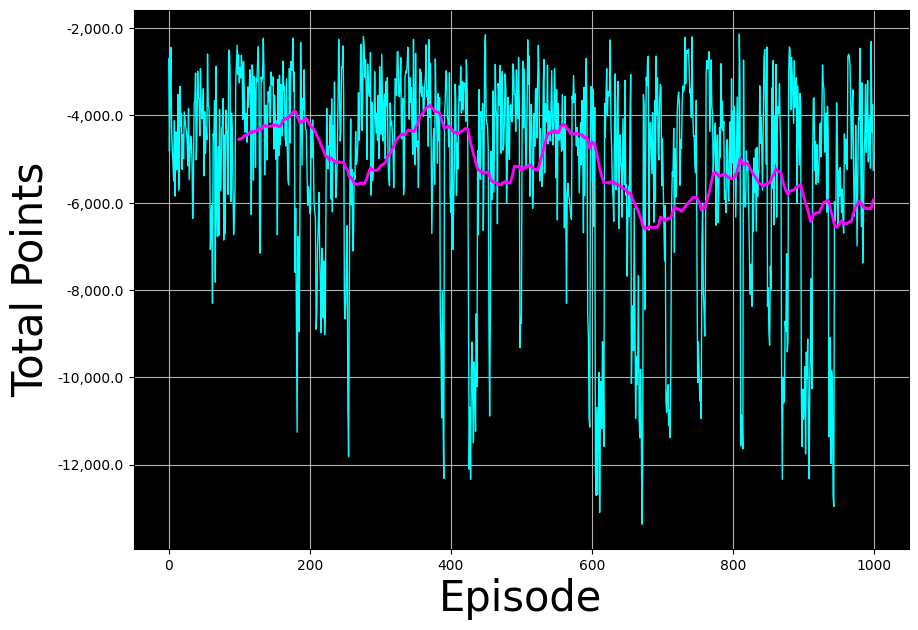

In [15]:
plot_history(episode_rewards)

## Test

In [16]:
EPISODES = 1
episode_rewards = []
for episode in range(1, EPISODES + 1):
    state = env.reset()
    done = False
    reward = 0
    env.render()
    print('')
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        episode_rewards.append(reward)
    env.render()
    print('')
    print(f"Episode: {episode}/{EPISODES}, Reward: {reward}\n")

green light timer [280. 407. 323. 456.]
avg waiting times (-) [1186. 1059. 1143. 1010.]
vehicles counts (-) [208. 156. 175. 185.]
in counts (+) [229. 453. 194. 106.]
out counts (+) [222.  78. 461. 295.]
avg speeds (+) [ 14. 419. 492.  65.]

green light timer [310. 187.  83. 486.]
avg waiting times (-) [756. 879. 983. 580.]
vehicles counts (-) [320. 357. 419. 333.]
in counts (+) [ 31. 187.  83. 440.]
out counts (+) [219. 195. 139. 187.]
avg speeds (+) [ 14. 419. 492.  65.]

Episode: 1/1, Reward: -4692.0



In [17]:
print(episode_rewards[0])
print(episode_rewards[-1])

-4333.0
-4692.0


In [18]:
env.render()

green light timer [310. 187.  83. 486.]
avg waiting times (-) [756. 879. 983. 580.]
vehicles counts (-) [320. 357. 419. 333.]
in counts (+) [ 31. 187.  83. 440.]
out counts (+) [219. 195. 139. 187.]
avg speeds (+) [ 14. 419. 492.  65.]
